# Using NP4VTT: Klein-Spady model

In this notebook, we show how to use a Klein-Spady estimator to estimate the distribution of the Value of Travel Time (VTT) from the Norway data.

## Step 1: Load modules and data, and create arrays

We first import the NP4VTT modules for creating the arrays, the Klein-Spady, and Pandas to load the dataset:

In [277]:
import sys
sys.path.append('../src')

In [278]:
import pandas as pd
import numpy as np
import py_np4vtt
from py_np4vtt.data_format import Vars
from py_np4vtt.model_kspady import ModelKSpady, ConfigKSpady
from py_np4vtt.data_import import make_modelarrays, compute_descriptives


Now we read the CSV file:

In [279]:
df = pd.read_table('../data/Norway09_data_v5.txt')
df.head()

,RespID,Mode,TravTime,BaseCost,Gender,AgeClass,IncClass,TravTimeClass,Purpose,CardID,...,TimeL,TimeR,Chosen,Quadrant2,Purpose2,Mode2,Income2,ExclGroup,Exclude_CDF,CS
0,88,1,25,27,1,3,5,1,1,1,...,32,25,1,4,1,1,3,4,1,1
1,88,1,25,27,1,3,5,1,1,2,...,25,28,2,2,1,1,3,4,1,2
2,88,1,25,27,1,3,5,1,1,3,...,29,25,1,4,1,1,3,4,1,3
3,88,1,25,27,1,3,5,1,1,4,...,32,25,1,2,1,1,3,4,1,4
4,88,1,25,27,1,3,5,1,1,5,...,29,32,2,2,1,1,3,4,1,5


The dataset contains 22 variables. Each row is a binary choice task. We will use:

* `RespID`: ID of each respondent.
* `Chosen`: Chosen alternative.
* `CostL`: Travel cost of alternatives 1 [NOK]
* `CostR`: Travel cost of alternatives 2 [NOK]
* `TimeL`: Travel time of alternatives 1 [minutes]
* `TimeR`: Travel time of alternatives 2 [minutes]

NP4VTT detects automatically the _slow and cheap_ and _fast and expensive_ alternative, for each choice situation. If NP4VTT finds violations to those two options (e.g., a fast-cheap) alternative, it will raise an error message.

Change currency of travel time to euros and change unit of travel time to hours

In [280]:
# Convert to euros
NOK2euro_exchange_rate = 9
df[['CostL','CostR']] = df[['CostL','CostR']] .div(NOK2euro_exchange_rate)

# convert to hours
df[['TimeL','TimeR']] = df[['TimeL','TimeR']] .div(60)

Now we create a dictionary to map the required variables for NP4VTT with the variables of the dataset:

In [281]:
columnarrays = {
    Vars.Id: 'RespID',
    Vars.ChosenAlt: 'Chosen',
    Vars.Cost1: 'CostL',
    Vars.Cost2: 'CostR',
    Vars.Time1: 'TimeL',
    Vars.Time2: 'TimeR',
}

And we create the required arrays:

In [282]:
model_arrays = make_modelarrays(df, columnarrays)

The function `make_modelarrays` creates six elements used by NP4VTT to estimate/train a model:

* `BVTT`: Contains the Boundary VTT per choice situation, computed from costs and time.
* `Choice`: A matrix of dummy variables that are equal to one if the respondent choose the fast-expensive alternative on each choice situation.
* `Accepts`: Number of times a respondent chose the fast-expensive alternative.
* `ID`: Unique identifier of each respondent.
* `NP`: Number of respondents in the dataset.
* `T`: Number of choice situations per respondent.

## Step 2: Compute descriptives

The function `compute_descriptives` provides a small overview of the dataset characteristics:

In [283]:
descriptives = compute_descriptives(model_arrays)
print(descriptives)

No. individuals: 5832
Sets per indiv.: 9

Number of non-traders:
Fast-exp. alt.: 144
Slow-cheap alt.: 808

BVTT statistics:
Mean chosen BVTT: 10.297654259295784
Minimum of BVTT: 0.6666666666666644
Maximum of BVTT: 113.56321839080461


## Step 3: Configure the Klein-Spady

The Klein-Spady requires the following parameters from the user:

* `minimum`: The minimum of the VTT grid.
* `maximum`: The maximum of the VTT grid.
* `supportPoints`: The number of support points.

The function `ConfigLocLogit` takes the configuration parameters of the Klein-Spady and creates an object that is used by the optimisation routine:

In [284]:
config = ConfigKSpady(minimum=1, maximum=100, supportPoints=10, kernelWidth = 2)

Now, we create the Klein-Spady object that contains the configuration parameters and the data arrays. Then, we initialise the arguments:

In [285]:
ks = ModelKSpady(config, model_arrays)

`ModelKSpady` creates the following specific arrays and can be accessed using the dot notation (e.g., ModelKSpady._object_):

- `vtt_grid`: the VTT grid as specified in `ConfigLocalLogit`.
- `k`: The kernel width used in the estimation routine.

## Step 4: Estimate a Klein-Spady estimator

Once the Klein-Spady object is initialised, the `run` method starts the optimisation process:

In [286]:
ecdf, vtt_grid = ks.run()

The estimated model returns the following information:

* `ecdf:` The cumulative probability of each point of the VTT grid.
* `vtt_grid:` The VTT grid

The following lines present the estimated results:

In [287]:
xx = pd.DataFrame(np.c_[vtt_grid,ecdf],columns=['VTT','p']).sort_values('VTT')

In [288]:
# Create dataframe
results = pd.DataFrame(np.c_[vtt_grid,ecdf],columns=['VTT','Cum. Prob.'],index=np.arange(len(vtt_grid)))

print('Estimation results:\n')
print('\nEstimated Cumulative probability:')
print(results)

Estimation results:


Estimated Cumulative probability:
     VTT  Cum. Prob.
0    1.0    0.250573
1   12.0    0.650855
2   23.0    0.821805
3   34.0    0.875164
4   45.0    0.912347
5   56.0    0.934377
6   67.0    0.924037
7   78.0    0.961810
8   89.0    0.923031
9  100.0    0.974440


## Step 5: Visualising the VTT distribution

We create the empirical Cumulative Density Function plot of the VTT distribution. For easy interpretation, we use create a histogram from the CDF. 
We use matplotlib for this:

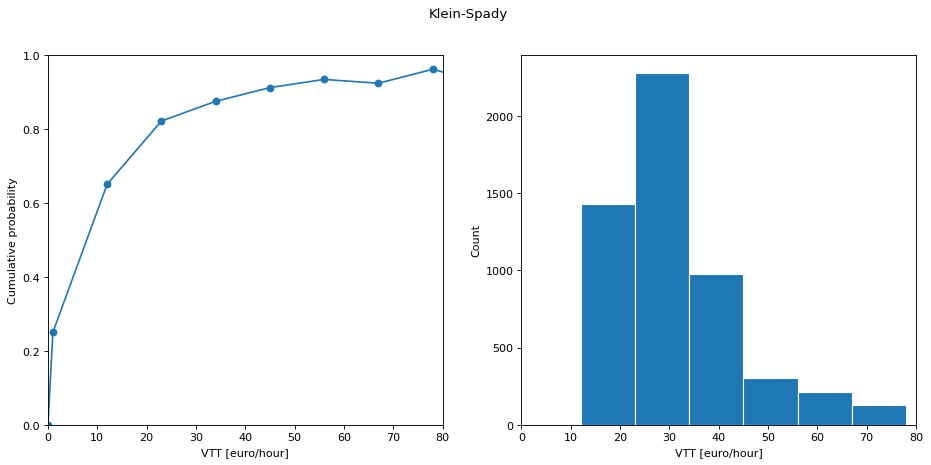

In [289]:
import matplotlib.pyplot as plt

# Obtain the midpoints from the vtt_grid
# vtt_grid_midpoints = ((np.append(vtt_grid, 0) + np.append(0,vtt_grid)))/2
# vtt_grid_midpoints[-1] = vtt_grid[-1]

fig, ax = plt.subplots(1,2,figsize=(14,6), dpi=80)

# Plot CDF
# ax[0].plot(vtt_grid_midpoints,np.concatenate((0,ecdf),axis=None),marker='o')
ax[0].plot(np.concatenate((0,vtt_grid),axis=None),np.concatenate((0,ecdf),axis=None),marker='o')
ax[0].set_xlim(0,80)
ax[0].set_ylim(0,1)
ax[0].set_xlabel('VTT [euro/hour]')
ax[0].set_ylabel('Cumulative probability')


# Obtain probabilities from the CDF plot
pp = ((np.append(ecdf, 0)-np.append(0,ecdf)))
pp[pp<0] = 0
pp = (np.divide(pp,np.sum(pp)))
pp[-1] = 0
pp = np.append(0,pp)

# Construct data points
data_hist = []
# for n in range(0,len(vtt_grid_midpoints)):
#     dat = [vtt_grid_midpoints[n]]*np.round((pp[n]*descriptives.NP)).astype(int)
#     data_hist = np.append(data_hist,dat)
for n in range(0,len(vtt_grid)):
    dat = [vtt_grid[n]]*np.round((pp[n]*descriptives.NP)).astype(int)
    data_hist = np.append(data_hist,dat)

# Plot histogram
ax[1].set_xlim(0,80)
ax[1].set_xlabel('VTT [euro/hour]')
ax[1].set_ylabel('Count')
ax[1].hist(data_hist, bins = vtt_grid,edgecolor="white")
fig.suptitle('Klein-Spady')
plt.show()